In [1]:
import pymc3 as pm
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import arviz as az
import re

## Data Processing

In [2]:
full = pd.read_csv("Data/full_data.csv")
full.head()

,Player,Pos,Age,Tm,G,MP,PER,TS%,3PAr,FTr,...,All_NBA_Pos,All_NBA_Team,All_NBA_Pts_Won,All_NBA_Pts_Max,All_NBA_Share,All_NBA_1st_Team_Votes,All_NBA_2nd_Team_Votes,All_NBA_3rd_Team_Votes,year,All_NBA_Boolean
0,Kareem Abdul-Jabbar*,C,41,LAL,74,1695,12.9,0.511,0.005,0.250,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1988-1989,False
1,Mark Acres,C,26,BOS,62,632,8.2,0.507,0.009,0.421,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1988-1989,False
2,Michael Adams,PG,26,DEN,77,2787,17.5,0.567,0.431,0.363,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1988-1989,False
3,Mark Alarie,PF,25,WSB,74,1141,13.3,0.531,0.088,0.202,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1988-1989,False
4,Randy Allen,SG,24,SAC,7,43,6.9,0.428,0.053,0.105,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1988-1989,False


We will need to remove the following columns because they are directly linked to the response variable.
- All_NBA_Pos: Position when considered for All NBA team. NA= no votes.
- All_NBA_Team: Which all-nba team the player was selected to (if any). ORV = player received votes for All-NBA team but did not make it. NA= no votes.
- All_NBA_Pts_Won: # of All-NBA points received. NA= no votes.
- All_NBA_Pts_Max: max number of All-NBA points possible for that year. Varies by year.NA= no votes.
- All_NBA_Share: share of All-NBA points won. All_NBA_Pts_Won/All_NBA_Pts_Max. This could be our response variable.
- All_NBA_1st_Team_Votes: # of 1st team votes
- All_NBA_2nd_Team_Votes: # of 2nd team votes
- All_NBA_3rd_Team_Votes: # of 3rd team votes

In [3]:
## Remove All ALL Stats except boolean All_Stars
remove_all_star = full.loc[:, ~full.columns.str.startswith('All_')]
remove_all_star["All_NBA_Boolean"] = full["All_NBA_Boolean"]
remove_all_star.head()

/var/folders/pn/dgy7ckd90nl7mlj6g6rc_1kw0000gn/T/ipykernel_44974/1871535054.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  remove_all_star["All_NBA_Boolean"] = full["All_NBA_Boolean"]


,Player,Pos,Age,Tm,G,MP,PER,TS%,3PAr,FTr,...,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,player_id,year,All_NBA_Boolean
0,Kareem Abdul-Jabbar*,C,41,LAL,74,1695,12.9,0.511,0.005,0.250,...,2.0,2.9,0.082,-1.9,-0.2,-2.1,0.0,abdulka01,1988-1989,False
1,Mark Acres,C,26,BOS,62,632,8.2,0.507,0.009,0.421,...,0.5,0.9,0.066,-3.0,-0.4,-3.4,-0.2,acresma01,1988-1989,False
2,Michael Adams,PG,26,DEN,77,2787,17.5,0.567,0.431,0.363,...,2.9,8.3,0.143,2.7,0.2,2.9,3.4,adamsmi01,1988-1989,False
3,Mark Alarie,PF,25,WSB,74,1141,13.3,0.531,0.088,0.202,...,1.0,2.2,0.093,-1.1,-0.8,-2.0,0.0,alarima01,1988-1989,False
4,Randy Allen,SG,24,SAC,7,43,6.9,0.428,0.053,0.105,...,0.0,0.0,-0.035,-5.5,-1.7,-7.2,-0.1,allenra01,1988-1989,False


In [4]:
clean_df = remove_all_star.dropna()
clean_df

,Player,Pos,Age,Tm,G,MP,PER,TS%,3PAr,FTr,...,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,player_id,year,All_NBA_Boolean
0,Kareem Abdul-Jabbar*,C,41,LAL,74,1695,12.9,0.511,0.005,0.250,...,2.0,2.9,0.082,-1.9,-0.2,-2.1,0.0,abdulka01,1988-1989,False
1,Mark Acres,C,26,BOS,62,632,8.2,0.507,0.009,0.421,...,0.5,0.9,0.066,-3.0,-0.4,-3.4,-0.2,acresma01,1988-1989,False
2,Michael Adams,PG,26,DEN,77,2787,17.5,0.567,0.431,0.363,...,2.9,8.3,0.143,2.7,0.2,2.9,3.4,adamsmi01,1988-1989,False
3,Mark Alarie,PF,25,WSB,74,1141,13.3,0.531,0.088,0.202,...,1.0,2.2,0.093,-1.1,-0.8,-2.0,0.0,alarima01,1988-1989,False
4,Randy Allen,SG,24,SAC,7,43,6.9,0.428,0.053,0.105,...,0.0,0.0,-0.035,-5.5,-1.7,-7.2,-0.1,allenra01,1988-1989,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15438,Tremont Waters,PG,24,TOT,3,50,5.4,0.357,0.643,0.000,...,0.1,0.0,-0.042,-7.8,0.1,-7.7,-0.1,watertr01,2021-2022,False
15439,Derrick White,SG,27,TOT,75,2199,14.8,0.549,0.461,0.294,...,2.3,5.1,0.111,0.4,0.6,0.9,1.6,whitede01,2021-2022,False
15440,Justise Winslow,SF,25,TOT,48,774,13.1,0.479,0.257,0.257,...,1.1,0.8,0.048,-2.7,1.0,-1.7,0.1,winslju01,2021-2022,False
15441,Moses Wright,PF,23,TOT,4,14,18.3,0.470,0.250,0.750,...,0.0,0.1,0.180,1.1,0.4,1.4,0.0,wrighmo01,2021-2022,False


Data Distribution by season 

In [5]:
clean_df.groupby(['year'])['All_NBA_Boolean'].count()

year
1988-1989    352
1989-1990    380
1990-1991    386
1991-1992    381
1992-1993    390
1993-1994    402
1994-1995    406
1995-1996    427
1996-1997    440
1997-1998    437
1998-1999    437
1999-2000    438
2000-2001    439
2001-2002    439
2002-2003    427
2003-2004    440
2004-2005    463
2005-2006    455
2006-2007    458
2007-2008    451
2008-2009    445
2009-2010    440
2010-2011    449
2011-2012    478
2012-2013    467
2013-2014    480
2014-2015    490
2015-2016    475
2016-2017    485
2017-2018    537
2018-2019    526
2019-2020    527
2020-2021    539
2021-2022    596
Name: All_NBA_Boolean, dtype: int64

## Hierarchical Modeling

The data has multiple seasons included in the dataframe. From our general knowledge we would suspect that each season, different categories of performance matters to select All NBA stars. Therefore, we can say that the data is nested and we would need to use a hierarchical model. 

First we will try to run a full hierarchical model with all the predictors that are numeric.

BY Position

In [6]:
def classify_position(arr):
    new_arr = []
    for i in arr:
        if 'C' in i:
            new_arr.append('C')
        elif 'F' in i:
            new_arr.append('F')
        elif 'G' in i:
            new_arr.append('G')
        else:
            new_arr.append(None)
    return new_arr
clean_df['Pos'] = classify_position(clean_df["Pos"])
clean_df

/var/folders/pn/dgy7ckd90nl7mlj6g6rc_1kw0000gn/T/ipykernel_44974/385451207.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_df['Pos'] = classify_position(clean_df["Pos"])


,Player,Pos,Age,Tm,G,MP,PER,TS%,3PAr,FTr,...,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,player_id,year,All_NBA_Boolean
0,Kareem Abdul-Jabbar*,C,41,LAL,74,1695,12.9,0.511,0.005,0.250,...,2.0,2.9,0.082,-1.9,-0.2,-2.1,0.0,abdulka01,1988-1989,False
1,Mark Acres,C,26,BOS,62,632,8.2,0.507,0.009,0.421,...,0.5,0.9,0.066,-3.0,-0.4,-3.4,-0.2,acresma01,1988-1989,False
2,Michael Adams,G,26,DEN,77,2787,17.5,0.567,0.431,0.363,...,2.9,8.3,0.143,2.7,0.2,2.9,3.4,adamsmi01,1988-1989,False
3,Mark Alarie,F,25,WSB,74,1141,13.3,0.531,0.088,0.202,...,1.0,2.2,0.093,-1.1,-0.8,-2.0,0.0,alarima01,1988-1989,False
4,Randy Allen,G,24,SAC,7,43,6.9,0.428,0.053,0.105,...,0.0,0.0,-0.035,-5.5,-1.7,-7.2,-0.1,allenra01,1988-1989,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15438,Tremont Waters,G,24,TOT,3,50,5.4,0.357,0.643,0.000,...,0.1,0.0,-0.042,-7.8,0.1,-7.7,-0.1,watertr01,2021-2022,False
15439,Derrick White,G,27,TOT,75,2199,14.8,0.549,0.461,0.294,...,2.3,5.1,0.111,0.4,0.6,0.9,1.6,whitede01,2021-2022,False
15440,Justise Winslow,F,25,TOT,48,774,13.1,0.479,0.257,0.257,...,1.1,0.8,0.048,-2.7,1.0,-1.7,0.1,winslju01,2021-2022,False
15441,Moses Wright,F,23,TOT,4,14,18.3,0.470,0.250,0.750,...,0.0,0.1,0.180,1.1,0.4,1.4,0.0,wrighmo01,2021-2022,False


In [7]:
## Drop Year
clean_df = clean_df.drop(columns=['year'])

In [8]:
season_idxs, seasons = pd.factorize(clean_df.Pos)
coords = {
    "season": seasons,
    "obs_id": np.arange(len(season_idxs)),
}
coords

{'season': Index(['C', 'G', 'F'], dtype='object'),
 'obs_id': array([    0,     1,     2, ..., 15379, 15380, 15381])}

We will also need to subset the numeric columns.

In [9]:
numeric_col = pd.DataFrame(clean_df.dtypes[:-1]).reset_index()
numeric_col = numeric_col[numeric_col[0] != 'object']
numeric_col.columns = ['name', 'type']
numeric_col = list(numeric_col.name)
numeric_col

['Age',
 'G',
 'MP',
 'PER',
 'TS%',
 '3PAr',
 'FTr',
 'ORB%',
 'DRB%',
 'TRB%',
 'AST%',
 'STL%',
 'BLK%',
 'TOV%',
 'USG%',
 'OWS',
 'DWS',
 'WS',
 'WS/48',
 'OBPM',
 'DBPM',
 'BPM',
 'VORP']

In [10]:
with pm.Model(coords=coords) as hierarchical_model:
    season_idx = pm.Data("season_idx", season_idxs, dims="obs_id")
    # Hyperpriors for group nodes
    mu_a = pm.Normal("mu_a", mu=0.0, sigma=10000)
    sigma_a = pm.HalfNormal("sigma_a", 5.0)

    
    # Intercept for each county, distributed around group mean mu_a
    # Above we just set mu and sd to a fixed value while here we
    # plug in a common group distribution for all a and b (which are
    # vectors of length n_counties).
    a = pm.Normal("a", mu=mu_a, sigma=sigma_a, dims="season")

    nba_est = a[season_idx]
    for i,col in enumerate(numeric_col):
        # Set mu for new predictor
        mu = pm.Normal("mu_b{}".format(i), mu=0.0, sigma=10000)
        # Set Sigma for new predictor
        sigma = pm.HalfNormal("sigma_b{}".format(i), 5.0)
        # Set beta for new predictor
        var = pm.Normal("b{}".format(i), mu=mu, sigma=sigma, dims="season")
        # Continous update of nba_est formula
        nba_est = nba_est + var[season_idx] * clean_df[col].values
    
    # Data likelihood
    nba_like = pm.Bernoulli(
        "nba_like",
        logit_p = nba_est,
        observed = clean_df.All_NBA_Boolean.astype(int).values
    )


In [11]:
with hierarchical_model:
    hierarchical_trace_full = pm.sample(1000, tune=1000, target_accept=0.9, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b22, sigma_b22, mu_b22, b21, sigma_b21, mu_b21, b20, sigma_b20, mu_b20, b19, sigma_b19, mu_b19, b18, sigma_b18, mu_b18, b17, sigma_b17, mu_b17, b16, sigma_b16, mu_b16, b15, sigma_b15, mu_b15, b14, sigma_b14, mu_b14, b13, sigma_b13, mu_b13, b12, sigma_b12, mu_b12, b11, sigma_b11, mu_b11, b10, sigma_b10, mu_b10, b9, sigma_b9, mu_b9, b8, sigma_b8, mu_b8, b7, sigma_b7, mu_b7, b6, sigma_b6, mu_b6, b5, sigma_b5, mu_b5, b4, sigma_b4, mu_b4, b3, sigma_b3, mu_b3, b2, sigma_b2, mu_b2, b1, sigma_b1, mu_b1, b0, sigma_b0, mu_b0, a, sigma_a, mu_a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 34481 seconds.
There were 86 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 97 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 85 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 94 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


/var/folders/pn/dgy7ckd90nl7mlj6g6rc_1kw0000gn/T/ipykernel_44974/3837209890.py:2: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  pm.plots.traceplot(hierarchical_trace_full)


array([[<AxesSubplot:title={'center':'mu_a'}>,
        <AxesSubplot:title={'center':'mu_a'}>],
       [<AxesSubplot:title={'center':'a'}>,
        <AxesSubplot:title={'center':'a'}>],
       [<AxesSubplot:title={'center':'mu_b0'}>,
        <AxesSubplot:title={'center':'mu_b0'}>],
       [<AxesSubplot:title={'center':'b0'}>,
        <AxesSubplot:title={'center':'b0'}>],
       [<AxesSubplot:title={'center':'mu_b1'}>,
        <AxesSubplot:title={'center':'mu_b1'}>],
       [<AxesSubplot:title={'center':'b1'}>,
        <AxesSubplot:title={'center':'b1'}>],
       [<AxesSubplot:title={'center':'mu_b2'}>,
        <AxesSubplot:title={'center':'mu_b2'}>],
       [<AxesSubplot:title={'center':'b2'}>,
        <AxesSubplot:title={'center':'b2'}>],
       [<AxesSubplot:title={'center':'mu_b3'}>,
        <AxesSubplot:title={'center':'mu_b3'}>],
       [<AxesSubplot:title={'center':'b3'}>,
        <AxesSubplot:title={'center':'b3'}>],
       [<AxesSubplot:title={'center':'mu_b4'}>,
        <AxesSub

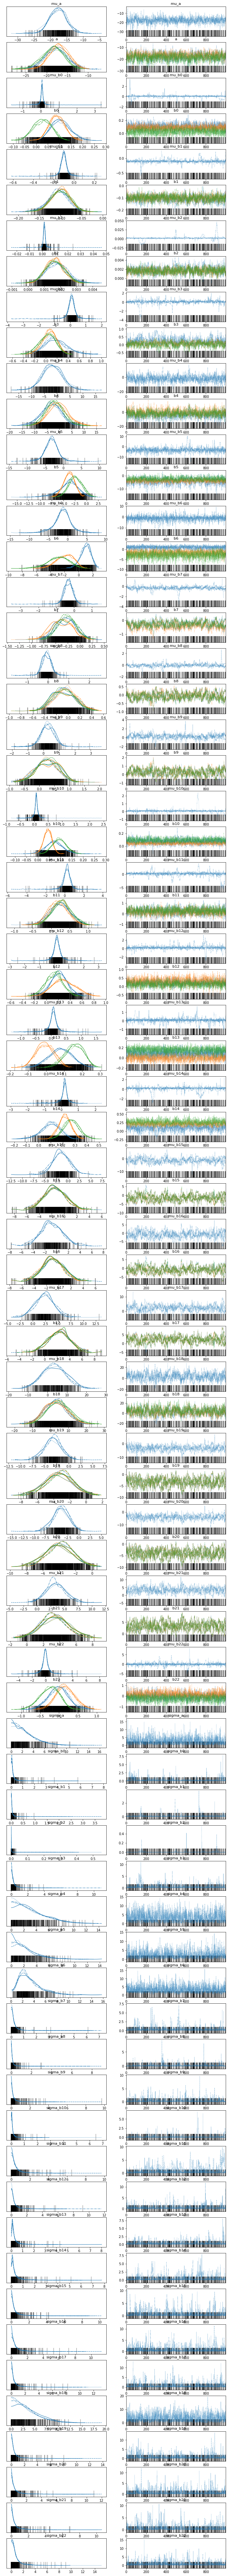

In [15]:
az.rcParams["plot.max_subplots"] = 200# This finishes without error
pm.plots.traceplot(hierarchical_trace_full)

In [13]:
sum_hierarchical_player = pm.summary(hierarchical_trace_full)
sum_hierarchical_player

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_a,-17.770,2.859,-23.198,-12.497,0.106,0.076,726.0,1036.0,1.01
a[C],-17.714,2.748,-22.689,-12.234,0.097,0.069,800.0,1561.0,1.01
a[G],-17.044,2.404,-21.741,-12.747,0.089,0.063,736.0,1314.0,1.00
a[F],-18.538,2.683,-23.823,-13.817,0.101,0.072,712.0,1391.0,1.01
mu_b0,0.053,0.223,-0.361,0.367,0.016,0.011,297.0,108.0,1.02
...,...,...,...,...,...,...,...,...,...
sigma_b18,3.341,2.626,0.022,8.219,0.099,0.070,576.0,530.0,1.01
sigma_b19,0.672,1.090,0.006,2.421,0.043,0.030,507.0,1159.0,1.00
sigma_b20,0.660,1.057,0.006,2.300,0.035,0.025,583.0,1167.0,1.00
sigma_b21,0.588,0.969,0.005,2.091,0.048,0.034,464.0,649.0,1.01


In [14]:
sum_hierarchical_player.sort_values('r_hat')

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
b13[F],0.155,0.053,0.052,0.246,0.002,0.001,1143.0,1619.0,1.00
b13[G],-0.006,0.051,-0.100,0.084,0.002,0.001,913.0,1524.0,1.00
b13[C],0.080,0.065,-0.043,0.202,0.002,0.001,1693.0,2433.0,1.00
b12[G],0.292,0.201,-0.057,0.676,0.006,0.004,1021.0,1741.0,1.00
b10[G],0.044,0.018,0.011,0.078,0.001,0.000,778.0,1824.0,1.00
...,...,...,...,...,...,...,...,...,...
b18[G],3.139,6.276,-8.372,15.124,0.357,0.252,312.0,735.0,1.02
mu_b11,0.173,0.701,-0.806,1.264,0.065,0.058,400.0,150.0,1.02
sigma_b2,0.003,0.016,0.000,0.008,0.001,0.001,210.0,129.0,1.02
mu_b18,3.604,6.293,-7.741,15.532,0.363,0.257,300.0,710.0,1.02
